In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, Dirichlet, Uniform

In [2]:
def plot_ratio_with_mc_error(df, num_trials, numerator_col, denominator_col):
    """
    Plot ratio of two columns from a DataFrame with Monte Carlo error bars.

    Parameters:
    - df: pandas DataFrame containing the data
    - num_trials: int, number of Monte Carlo trials (used for estimating error bars)
    - numerator_col: str, name of the column to use as numerator
    - denominator_col: str, name of the column to use as denominator
    """
    ratio_col = "var_to_bound_ratio"
    error_col = "mc_std_err"

    # Compute ratio and standard error
    df[ratio_col] = df[numerator_col] / df[denominator_col]
    df[error_col] = df[ratio_col] / np.sqrt(num_trials)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.errorbar(df["n"], df[ratio_col], yerr=df[error_col],
                 fmt='o-', capsize=4, label=f"{numerator_col} / {denominator_col}")
    plt.axhline(1.0, color='gray', linestyle='--', label='Ratio = 1')
    plt.xlabel("Sample Size (n)")
    plt.ylabel("Ratio")
    plt.title("Ratio with Monte Carlo Error Bars")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

First we verify that CLT works for the linear regression problem $Y = XB + E$, where $B$ is a rotation matrix parametrized by $\theta$, and $E$ is a random matrix with i.i.d. $N(0, \sigma)$ entries. True $B$ is assumed to be $I_2$.

In particular, we want to compare the variance of $\theta$ and the predicted variance given by the curved Fisher's Information. 

In [3]:
def orthogonal_procrustes(X, Y, enforce_rotation=False):
    """
    Solves the orthogonal Procrustes problem:
        min_B || Y - X B ||_F^2
    subject to: B ∈ O_p (orthogonal matrix)
    
    Parameters:
        enforce_rotation (bool): If True, ensures det(B)=+1 (proper rotation)
        return_theta (bool): If True and B is 2x2, also return the angle θ (in radians)

    Returns:
        B (optimal orthogonal matrix)
        θ (optimal rotation angle)
    """
    M = X.T @ Y
    U, _, Vt = torch.linalg.svd(M, full_matrices=False)
    B = U @ Vt

    if enforce_rotation:
        det = torch.linalg.det(B)
        if det < 0:
            Vt[-1, :] *= -1
            B = U @ Vt


    if B.shape != (2, 2):
        raise ValueError("return_theta=True is only supported for 2x2 matrices.")
    theta = torch.atan2(B[1, 0], B[0, 0])  # atan2(sinθ, cosθ)
    return B, theta

def rotation_matrix(theta):
    
    c, s = torch.cos(theta), torch.sin(theta)
    B =  torch.stack([
        torch.stack([c, -s]),
        torch.stack([s,  c])
    ])
    
    return B
    
def Curved_FI_rotation_lin_reg(X, sigma, theta):
    
    theta = torch.tensor(theta, dtype=X.dtype)
    c, s = torch.cos(theta), torch.sin(theta)
    B_deriv = torch.stack([
        torch.stack([-s, -c]),
        torch.stack([c,  -s])
    ])  # dB/dtheta
    I_curved = (1 / sigma**2) * torch.norm(X @ B_deriv, p = 'fro')**2
    
    return I_curved

def gen_Y(X, sigma, true_theta = 0):
    
    n, p = X.shape
    true_theta = torch.tensor(true_theta, dtype=X.dtype)
    normal = Normal(0, sigma)
    
    B = rotation_matrix(true_theta)
    noise = normal.sample((n, p))
    Y = X @ B + noise
    return(Y)

In [4]:
def rotation_reg_variance_simulation(num_trials, n_min, n_max, n_step_size, sigma = 0.02, true_theta = 0):
    unif = Uniform(0, 1)
    var_list = []
    for n in range(n_min, n_max, n_step_size):
        X = unif.sample((n, 2))
        Curved_FI = Curved_FI_rotation_lin_reg(X, sigma, true_theta)
        theta_hat_list = []
        for _ in range(num_trials):
            Y = gen_Y(X, sigma, true_theta)
            B_hat, theta_hat = orthogonal_procrustes(X, Y, True)
            theta_hat_list.append(theta_hat)
        theta_var = {"n": n, 
                     "num_trials": torch.tensor(theta_hat_list).var().item(),
                     "inv_Curved_FI": (1/Curved_FI).item()}
        var_list.append(theta_var)
    df = pd.DataFrame(var_list)
    return(df)
            


In [172]:
num_trials = 10000
df_rotation = rotation_reg_variance_simulation(num_trials = num_trials, 
                                      n_min = 1000, 
                                      n_max = 10000, 
                                      n_step_size = 1000)

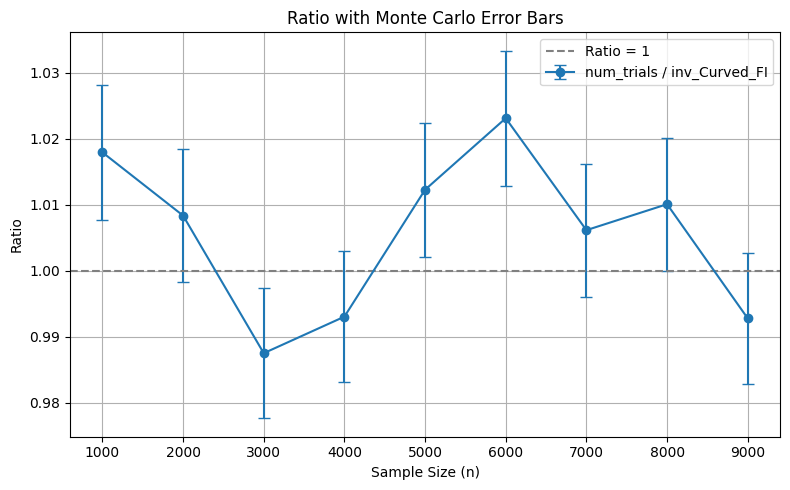

In [173]:
plot_ratio_with_mc_error(df_rotation, num_trials, "num_trials" , "inv_Curved_FI")

Now we move on to the same regression problem, but $B \in O_p$ instead of the rotation matrix constraint. $B$ can still be solved the same way, but due to the lack of parametrization, we have to replace the Jacobian of $B(\theta)$ with a matrix whose columns are orthonormal bases of $T_I(O_p)$ (since we are assuming that $B = I_2$).

In [5]:
def skew_symmetric_basis(p):
    """
    Returns a matrix whose columns are the vectorized orthonormal basis elements
    of the space of p x p skew-symmetric matrices.

    Output shape: (p^2, d), where d = p(p-1)/2
    """
    basis_list = []
    for i in range(p):
        for j in range(i+1, p):
            E = torch.zeros((p, p))
            E[i, j] = 1 / torch.sqrt(torch.tensor(2.0))
            E[j, i] = -1 / torch.sqrt(torch.tensor(2.0))
            basis_list.append(E.reshape(-1))  # vectorize

    basis_matrix = torch.stack(basis_list, dim=1)  # shape (p^2, d)
    return basis_matrix


def project_to_tangent_space(Delta, basis_matrix):
    """
    Project a matrix Delta onto the tangent space spanned by an orthonormal basis.
    
    Parameters:
        Delta         : (p x p) matrix of deviations (e.g., W_hat - I)
        basis_matrix  : (p^2 x d) matrix, each column is a vectorized orthonormal basis element of T_I(O_p)
    
    Returns:
        projection    : (p x p) matrix, projection of Delta into tangent space
        coeffs        : (d,) tensor, coefficients of Delta along each basis direction
    """
    p_squared, d = basis_matrix.shape
    Delta_vec = Delta.reshape(-1)                 # shape (p^2,)
    coeffs = basis_matrix.T @ Delta_vec           # shape (d,)
    projection_vec = basis_matrix @ coeffs        # shape (p^2,)
    projection_matrix = projection_vec.reshape(Delta.shape)  # shape (p x p)
    
    return projection_matrix, coeffs

def Curved_FI_Op_lin_reg(X, sigma):
    """
    Compute curved Fisher Information matrix for orthogonally constrained regression model.
    
    Parameters:
        X     : (n x p) design matrix
        sigma : noise std deviation

    Returns:
        FI_curved : (d x d) Fisher Information projected onto skew-symmetric tangent space
    """
    n, p = X.shape
    basis_mat = skew_symmetric_basis(p)  # (p^2 x d)
    
    FI_full = (1 / sigma**2) * torch.kron(torch.eye(p), X.T @ X)  # (p^2 x p^2)
    FI_curved = basis_mat.T @ FI_full @ basis_mat                 # (d x d)
    
    return FI_curved


def compute_empirical_cov(coeff_matrix):
    """
    Computes unbiased empirical covariance matrix for coeff_matrix (num_trials x d).
    """
    num_trials = coeff_matrix.shape[0]
    mean = coeff_matrix.mean(dim=0, keepdim=True)
    centered = coeff_matrix - mean
    cov = (centered.T @ centered) / (num_trials - 1)
    return cov

def Op_reg_variance_simulation(num_trials, n_min, n_max, n_step_size, sigma=0.02, p=2):
    unif = Uniform(0, 1)
    var_list = []

    for n in range(n_min, n_max, n_step_size):
        X = unif.sample((n, p))
        FI_curved = Curved_FI_Op_lin_reg(X, sigma)
        basis_mat = skew_symmetric_basis(p)

        coeff_matrix = []

        for _ in range(num_trials):
            Y = gen_Y(X, sigma)  # assumes default true_W = identity
            W_hat = orthogonal_procrustes(X, Y, enforce_rotation=False)[0]  # full O(p), not just rotation
            Delta = W_hat - torch.eye(p)
            _, coeffs = project_to_tangent_space(Delta, basis_mat)
            coeff_matrix.append(coeffs)

        coeff_matrix = torch.stack(coeff_matrix, dim=0)  # shape (num_trials x d)
        empirical_cov = compute_empirical_cov(coeff_matrix)  # (d x d)

        var_record = {
            "n": n,
            "empirical_cov_trace": empirical_cov.trace().item(),
            "inv_Curved_FI_trace": torch.linalg.inv(FI_curved).trace().item()
        }
        var_list.append(var_record)

    df = pd.DataFrame(var_list)
    return df

In [175]:
num_trials = 10000
df_Op = Op_reg_variance_simulation(num_trials = num_trials, 
                                      n_min = 1000, 
                                      n_max = 10000, 
                                      n_step_size = 1000)

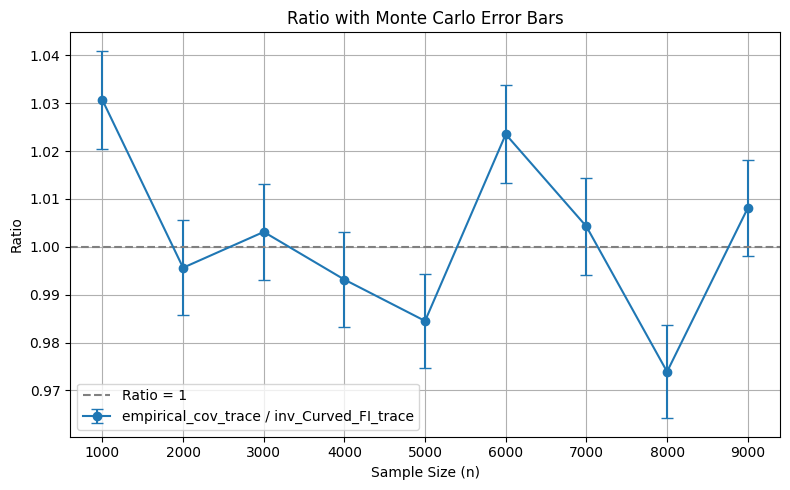

In [179]:
plot_ratio_with_mc_error(df_Op, num_trials, "empirical_cov_trace", "inv_Curved_FI_trace")

In [340]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
device = 'cuda'

# class GaussianPenaltyLoss2D(nn.Module):
#     def __init__(self, sigma):
#         super().__init__()
#         self.sigma = sigma
#         self.theta = nn.Parameter(torch.tensor(0.0))  # learnable scalar angle

#     def rotation_matrix(self):
#         c = torch.cos(self.theta)
#         s = torch.sin(self.theta)
#         return torch.stack([
#             torch.stack([c, -s]),
#             torch.stack([s,  c])
#         ])  # shape (2 x 2)

#     def forward(self, Z):
#         """
#         Z: (n x 2) matrix — each row is a vector z
#         Returns: scalar total loss over all rows
#         """
#         V = self.rotation_matrix()
#         VZ = Z @ V
#         scaled = VZ / self.sigma

#         normal = Normal(0, self.sigma)  # updated location
#         phi = normal.log_prob(-scaled).exp()
#         Phi = normal.cdf(-scaled)

#         loss_per_row = torch.sum(phi - scaled * Phi, dim=1) * self.sigma
#         total_loss = loss_per_row.sum()
#         return total_loss

#     def optimize_theta_newton(self, Z, max_steps=100, tolerance=1e-6, verbose=False):
#         for step in range(max_steps):
#             loss = self.forward(Z)
#             grad = torch.autograd.grad(loss, self.theta, create_graph=True)[0]
#             hess = torch.autograd.grad(grad, self.theta)[0]

#             if hess.abs() < 1e-10:  # avoid divide-by-zero or flat curvature
#                 if verbose:
#                     print(f"[Step {step}] Hessian too small ({hess.item():.2e}), stopping.")
#                 break

#             step_size = grad / hess
#             with torch.no_grad():
#                 self.theta -= step_size

#             if verbose:
#                 print(f"[Step {step}] θ: {self.theta.item():.6f}, Loss: {loss.item():.6f}, ∇: {grad.item():.4e}, H: {hess.item():.4e}")

#             if grad.abs() < tolerance:
#                 if verbose:
#                     print(f"Converged at step {step}, ∇θ ≈ 0")
#                 break

#         return self.theta.detach()
    
class GaussianPenaltyLoss2D(nn.Module):
    def __init__(self, sigma, device='cpu'):
        super().__init__()
        self.sigma = sigma
        self.device = device
        self.theta = nn.Parameter(torch.tensor(0.0, device=device))  # scalar angle on device

    def rotation_matrix(self):
        c = torch.cos(self.theta)
        s = torch.sin(self.theta)
        return torch.stack([
            torch.stack([c, -s]),
            torch.stack([s,  c])
        ])  # shape (2 x 2), already on same device as theta

    def forward(self, Z):
        """
        Z: (n x 2) matrix — each row is a vector z
        Returns: scalar total loss over all rows
        """
        Z = Z.to(self.device)  # ensure Z is on the same device
        V = self.rotation_matrix()
        VZ = Z @ V
        scaled = VZ / self.sigma

        normal = Normal(loc=torch.tensor(0.0, device=self.device), scale=self.sigma)
        phi = normal.log_prob(-scaled).exp()
        Phi = normal.cdf(-scaled)

        loss_per_row = torch.sum(phi - scaled * Phi, dim=1) * self.sigma
        total_loss = loss_per_row.sum()
        return total_loss

    def optimize_theta_newton(self, Z, max_steps=100, tolerance=1e-6, verbose=False):
        Z = Z.to(self.device)  # ensure Z is on the correct device
        for step in range(max_steps):
            loss = self.forward(Z)
            grad = torch.autograd.grad(loss, self.theta, create_graph=True)[0]
            hess = torch.autograd.grad(grad, self.theta)[0]

            if hess.abs() < 1e-10:
                if verbose:
                    print(f"[Step {step}] Hessian too small ({hess.item():.2e}), stopping.")
                break

            step_size = grad / hess
            with torch.no_grad():
                self.theta -= step_size

            if verbose:
                print(f"[Step {step}] θ: {self.theta.item():.6f}, Loss: {loss.item():.6f}, ∇: {grad.item():.4e}, H: {hess.item():.4e}")

            if grad.abs() < tolerance:
                if verbose:
                    print(f"Converged at step {step}, ∇θ ≈ 0")
                break

        return self.theta.cpu().detach()


def loss_hessian_vecV(X, V, sigma):
    """
    Computes the summed Hessian of the loss with respect to vec(V), across all rows of Z.
    
    Parameters:
        X     : (n x p) matrix
        V     : (p x p) orthogonal matrix
        sigma : scalar (noise standard deviation)
        
    Returns:
        H     : (p^2 x p^2) Hessian matrix
    """
    n, p = X.shape
    H = torch.zeros((p*p, p*p), dtype=V.dtype, device=V.device)

    vecV = V.reshape(-1, 1)  # shape (p^2 x 1)

    normal = Normal(0, sigma)

    for i in range(n):
        z = X[i]  # shape (p,)
        z_kron_I = torch.kron(z, torch.eye(p, device=V.device))  # shape (p x p^2)

        proj = (z_kron_I @ vecV).flatten()  # shape (p,)
        phi = normal.log_prob(-proj/sigma).exp()  # Gaussian PDF evaluated at -proj
        D = torch.diag(phi)  # shape (p x p)

        hess_i = (1 / sigma) * z_kron_I.T @ D @ z_kron_I  # shape (p^2 x p^2)
        H += hess_i

    return H

def Curved_FI_Op_custom(X, V, sigma):
    """
    Compute curved Fisher Information matrix for orthogonally constrained custom model at V
    
    Parameters:
        X     : (n x p) design matrix
        V     : (p x p) orthogonal matrix
        sigma : noise std deviation

    Returns:
        FI_curved : (d x d) Fisher Information projected onto skew-symmetric tangent space
    """
    n, p = X.shape
    basis_mat = skew_symmetric_basis(p)  # (p^2 x d)
    
    FI_full = loss_hessian_vecV(X, V, sigma)  # (p^2 x p^2)
    FI_curved = basis_mat.T @ FI_full @ basis_mat                 # (d x d)
    
    return FI_curved


In [335]:
def penalty_reg_variance_simulation_custom(num_trials, n_min, n_max, n_step_size, sigma=0.02, p=2):
    assert p == 2, "GaussianPenaltyLoss2D currently supports only p=2 (rotation matrix case)"
    
    unif = Uniform(0, 1)
    var_list = []

    for n in range(n_min, n_max, n_step_size):
        print(n)
        X = unif.sample((n, p))
        
        # Use current V = identity (true value)
        V = torch.eye(p)
        FI_curved = Curved_FI_Op_custom(X, V, sigma)  # (d x d)
        basis_mat = skew_symmetric_basis(p)  # (p^2 x d), where d = p(p-1)/2

        coeff_matrix = []
        theta_list = []
        for _ in range(num_trials):
            Y = gen_Y(X, sigma)  # assumes true_W = I
            model = GaussianPenaltyLoss2D(sigma=sigma)
            model.optimize_theta_newton(Y)
            
            # Get learned rotation matrix
            V_hat = model.rotation_matrix().detach()
            
            Delta = V_hat - torch.eye(p)
            _, coeffs = project_to_tangent_space(Delta, basis_mat)
            coeff_matrix.append(coeffs)
            theta_list.append(model.theta)

        coeff_matrix = torch.stack(coeff_matrix, dim=0)  # (num_trials x d)
        empirical_cov = compute_empirical_cov(coeff_matrix)  # (d x d)
        theta_mean = torch.tensor(theta_list).mean()
        theta_var = torch.tensor(theta_list).var()
        var_record = {
            "n": n,
            "theta_m": theta_mean,
            "theta_v": theta_var,
            "empirical_cov_trace": empirical_cov.trace().item(),
            "inv_Curved_FI_trace": torch.linalg.inv(FI_curved).trace().item()
        }
        var_list.append(var_record)

    df = pd.DataFrame(var_list)
    return df

In [341]:
num_trials = 100
df_Op = penalty_reg_variance_simulation_custom(num_trials = num_trials, 
                                      n_min = 10000, 
                                      n_max = 100001, 
                                      n_step_size = 20000)

10000
30000
50000
70000
90000


In [343]:
df_Op

,n,theta_m,theta_v,empirical_cov_trace,inv_Curved_FI_trace
0,10000,tensor(-0.0005),tensor(9.1027e-05),0.000182,0.000468
1,30000,tensor(-0.0011),tensor(0.0006),0.001209,0.000218
2,50000,tensor(0.0047),tensor(0.0020),0.003756,0.000142
3,70000,tensor(-0.0019),tensor(0.0002),0.000374,0.000073
4,90000,tensor(0.0004),tensor(9.9782e-05),0.000199,0.000069


In [342]:
df_Op['empirical_cov_trace']/df_Op['inv_Curved_FI_trace']

0     0.388841
1     5.556811
2    26.415823
3     5.140059
4     2.893761
dtype: float64

In [333]:
def plot_X_Y(X, Y, color_X='blue', color_Y='orange', label_X='X', label_Y='Y', alpha_X = 0.7, alpha_Y = 0.7):
    """
    Scatter plot of X and Y (n x 2) matrices with different colors.

    Parameters:
        X, Y     : (n x 2) torch.Tensor or numpy.ndarray
        color_X  : color for X points
        color_Y  : color for Y points
        label_X  : label for legend for X
        label_Y  : label for legend for Y
    """
    # Convert to numpy if they are torch tensors
    if hasattr(X, 'numpy'):
        X = X.detach().cpu().numpy()
    if hasattr(Y, 'numpy'):
        Y = Y.detach().cpu().numpy()

    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], color=color_X, label=label_X, alpha=alpha_X)
    plt.scatter(Y[:, 0], Y[:, 1], color=color_Y, label=label_Y, alpha=alpha_Y)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend()
    plt.title("Scatter plot of X and Y")
    plt.grid(True)
    plt.axis("equal")
    plt.tight_layout()
    plt.show()
    


# Your GaussianPenaltyLoss2D class — make sure it's already defined above

def plot_loss_landscape(Y, sigma=0.02, num_points=1000, plot = True):
    thetas = torch.linspace(-np.pi/10, np.pi/10, num_points)
    losses = []

    # Create a temporary model object just for evaluation
    model = GaussianPenaltyLoss2D(sigma=sigma)

    for theta_val in thetas:
        model.theta.data = theta_val.clone().detach()  # manually set theta
        loss_val = model.forward(Y).item()
        losses.append(loss_val)
    
    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(thetas.numpy(), losses, label='Loss vs θ')
        plt.axvline(x=0, color='gray', linestyle='--', label='θ=0 (Identity)')
        plt.xlabel("θ (radians)")
        plt.ylabel("Loss")
        plt.title("Loss Landscape of GaussianPenaltyLoss2D")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    min_index = torch.argmin(torch.tensor(losses)).item()
    best_theta = thetas[min_index]
    return(min(losses), best_theta)


tensor(0.0002)


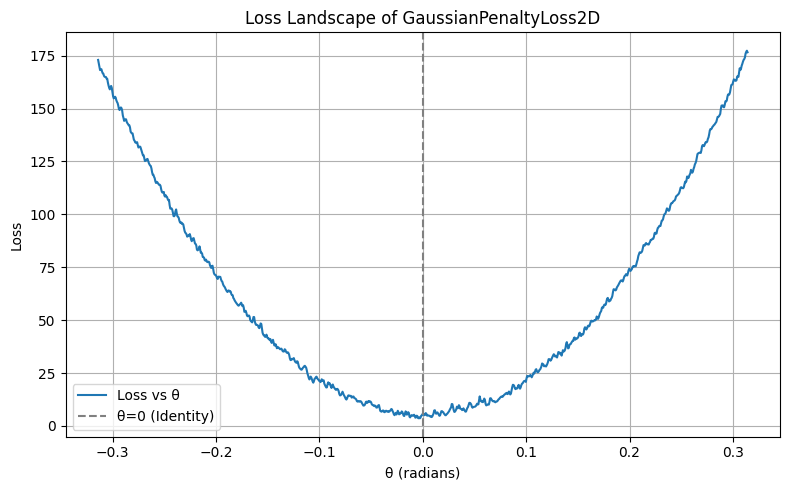

(3.5990233421325684, tensor(-0.0028))

In [334]:
unif = Uniform(0, 1)
n, p, sigma = 10000, 2, 0.02

X = unif.sample((n, p))
Y = gen_Y(X, sigma)  # assumes true_W = I
model = GaussianPenaltyLoss2D(sigma=sigma)
print(model.optimize_theta_newton(Y, verbose= False))

plot_loss_landscape(Y, sigma= sigma, plot = True)

In [346]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def rotation_matrix(theta):
    c = torch.cos(theta)
    s = torch.sin(theta)
    return torch.stack([
        torch.stack([c, -s]),
        torch.stack([s,  c])
    ])  # shape (2 x 2)

def plot_rotation_regression_loss(Y, X, theta_range=(-np.pi/20, np.pi/20), num_points=500, title="Loss vs θ"):
    """
    Plots the Frobenius loss ||Y - X B(theta)||_F^2 for a range of θ.

    Parameters:
        Y           : (n x 2) target matrix
        X           : (n x 2) design matrix
        theta_range : tuple (min_theta, max_theta) in radians
        num_points  : number of θ values to evaluate
        title       : plot title
    """
    thetas = torch.linspace(theta_range[0], theta_range[1], num_points)
    losses = []

    for theta in thetas:
        B = rotation_matrix(theta)
        residual = Y - X @ B
        loss = torch.norm(residual, p='fro')**2
        losses.append(loss.item())

    plt.figure(figsize=(8, 5))
    plt.plot(thetas.numpy(), losses, label=r"$\|Y - X B(\theta)\|_F^2$")
    plt.xlabel("θ (radians)")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True)
    plt.axvline(x=0, color='gray', linestyle='--', label='θ = 0')
    plt.legend()
    plt.tight_layout()
    plt.show()


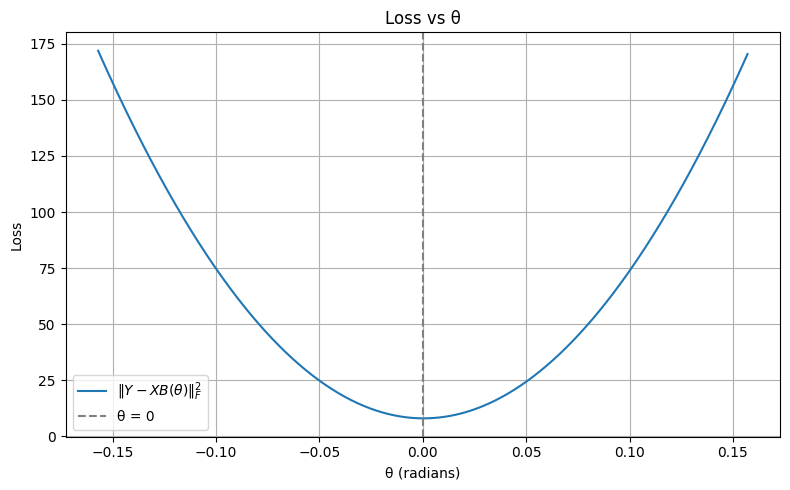

In [348]:
X = unif.sample((n, 2))
Y = gen_Y(X, sigma = sigma, true_theta= 0)
plot_rotation_regression_loss(Y, X)